In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('/Users/pchaberski/projects/image-embeddings')

In [3]:
import torch
from data.hm_data import HMDataset
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import pandas as pd

In [4]:
from utils.configuration import load_config
# from utils.logger import configure_logger
import neptune.new as neptune
import os
from model.autoencoder_module import LitHMAutoEncoder
import pytorch_lightning as pl
from importlib import import_module

In [5]:
cfg = load_config('config.yml')

---

Test data class

In [6]:
data_train_scaled = HMDataset(
    data_path=os.path.join(cfg.get('data_path'), 'train'),
    center=False,
    center_params=cfg.get('center_params')
)

data_train_centered = HMDataset(
    data_path=os.path.join(cfg.get('data_path'), 'train'),
    center=True,
    center_params=cfg.get('center_params')
)

In [7]:
idx = 666

tens_scaled = data_train_scaled[idx]
tens_centered = data_train_centered[idx]

print('Original, scaled 0-1:')
print(torch.min(tens_scaled), torch.max(tens_scaled))
print('Center:')
print(torch.min(tens_centered), torch.max(tens_centered))

Original, scaled 0-1:
tensor(0.2588) tensor(0.9333)
Center:
tensor(-2.5306) tensor(0.8343)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


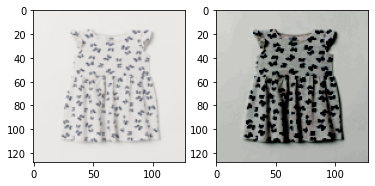

In [8]:
_, axarr = plt.subplots(1, 2)
axarr[0].imshow(tens_scaled.permute(1, 2, 0))
axarr[1].imshow(tens_centered.permute(1, 2, 0))

___

In [9]:
data_valid = HMDataset(
    data_path=os.path.join(cfg.get('data_path'), 'valid'),
    center=cfg.get('centered'),
    center_params=cfg.get('center_params')
)

In [10]:
model = LitHMAutoEncoder(
    data_path=cfg.get('data_path'),
    batch_size=cfg.get('batch_size'),
    encoder=getattr(import_module('model.encoders'), cfg.get('encoder'))(cfg.get('embedding_size')),
    decoder=getattr(import_module('model.decoders'), cfg.get('decoder'))(cfg.get('embedding_size')),
    num_workers=cfg.get('num_workers'),
    center=cfg.get('center'),
    center_params=cfg.get('center_params'),
    optimizer=getattr(import_module('torch.optim'), cfg.get('optimizer')),
    optimizer_params=cfg.get('optimizer_params'),
    # run=run
)

In [11]:
trainer = pl.Trainer(
    max_epochs=cfg.get('num_epochs'),
    gpus=cfg.get('num_gpus'),
    num_sanity_val_steps=0
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [12]:
trainer.fit(model)


  | Name    | Type        | Params
----------------------------------------
0 | encoder | EncoderBase | 6.3 M 
1 | decoder | DecoderBase | 6.3 M 
----------------------------------------
12.6 M    Trainable params
0         Non-trainable params
12.6 M    Total params
50.562    Total estimated model params size (MB)
/opt/miniconda3/envs/image-embeddings/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/miniconda3/envs/image-embeddings/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 whic

Epoch 0: 100%|██████████| 64/64 [00:23<00:00,  2.67it/s, loss=0.0807, v_num=206]


In [13]:
iter(model.train_dataloader())

In [14]:
def imshow(img):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.pause(1)
    plt.close()

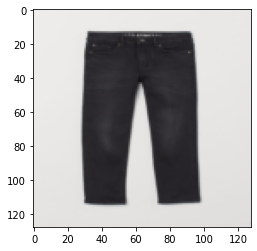

In [15]:
imshow(data_valid[0])

In [16]:
# data_iter = iter(data_module.val_dataloader())
data_iter = iter(model.val_dataloader())

In [17]:
sample_size = 16

In [18]:
sample_images = data_iter.next()[:sample_size, :, :, :]
sample_images.shape

torch.Size([16, 3, 128, 128])

In [19]:
torchvision.utils.make_grid(sample_images).shape

torch.Size([3, 262, 1042])

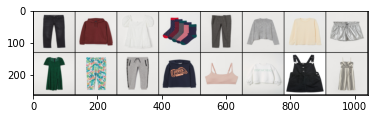

In [20]:
imshow(torchvision.utils.make_grid(sample_images))

In [21]:
model.freeze()
model.eval()
embeddings = model.encoder(sample_images.reshape(sample_size, model.image_size[0]*model.image_size[1]*3))
embeddings.shape

torch.Size([16, 32])

In [22]:
embeddings.numpy()

array([[ 0.6173228 , -1.2039555 , -0.26320198, -0.30260915, -0.3139031 ,
        -1.5629327 , -0.5199307 ,  0.4756676 ,  1.1321424 , -3.0947843 ,
        -2.672719  , -0.5520845 , -1.9153812 ,  0.27738914,  0.14777856,
         0.15707605, -0.73765504, -1.0451069 , -1.7173374 ,  1.158822  ,
         0.31784636, -0.12873974,  0.87287796, -0.52995336,  1.2452365 ,
         1.981085  ,  0.25332463,  0.13529979,  2.95396   ,  0.00862712,
        -0.84006244,  1.4184684 ],
       [ 0.60708606, -1.1093293 , -0.2493676 , -0.298788  , -0.28085864,
        -1.472465  , -0.49079728,  0.44777322,  1.0439943 , -2.9028249 ,
        -2.4999406 , -0.51067996, -1.8177971 ,  0.26243293,  0.16996925,
         0.15340017, -0.7319829 , -0.95923483, -1.6230237 ,  1.1108828 ,
         0.31460765, -0.1357362 ,  0.8540266 , -0.516275  ,  1.1758941 ,
         1.8833425 ,  0.24110973,  0.16258268,  2.77508   ,  0.02441424,
        -0.80164826,  1.3307751 ],
       [ 0.876748  , -1.7451941 , -0.40798527, -0.4433

In [23]:
pd.DataFrame(embeddings.numpy())

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.617323,-1.203956,-0.263202,-0.302609,-0.313903,-1.562933,-0.519931,0.475668,1.132142,-3.094784,...,0.872878,-0.529953,1.245237,1.981085,0.253325,0.135300,2.953960,0.008627,-0.840062,1.418468
1,0.607086,-1.109329,-0.249368,-0.298788,-0.280859,-1.472465,-0.490797,0.447773,1.043994,-2.902825,...,0.854027,-0.516275,1.175894,1.883343,0.241110,0.162583,2.775080,0.024414,-0.801648,1.330775
2,0.876748,-1.745194,-0.407985,-0.443330,-0.440042,-2.252823,-0.747690,0.668650,1.590982,-4.363265,...,1.254635,-0.792219,1.739130,2.806423,0.379207,0.189518,4.169246,0.058382,-1.200781,2.004876
3,0.670522,-1.234264,-0.283949,-0.333373,-0.308864,-1.634763,-0.544452,0.492911,1.149107,-3.198645,...,0.946993,-0.580069,1.291620,2.078565,0.271158,0.178817,3.059004,0.038376,-0.887407,1.467636
4,0.681462,-1.342937,-0.299570,-0.337278,-0.347069,-1.737959,-0.577662,0.524810,1.250524,-3.418406,...,0.967528,-0.595029,1.370861,2.189734,0.284958,0.146628,3.263656,0.019676,-0.930950,1.568002
5,0.789849,-1.556652,-0.358685,-0.396364,-0.395015,-2.015479,-0.669406,0.602002,1.430360,-3.924334,...,1.126385,-0.704040,1.568763,2.523518,0.336324,0.174266,3.749219,0.043471,-1.077561,1.802066
6,0.862072,-1.691023,-0.397184,-0.435926,-0.423884,-2.193464,-0.728329,0.651214,1.542509,-4.245889,...,1.231821,-0.776312,1.695164,2.738782,0.369756,0.195908,4.058409,0.061273,-1.172601,1.950951
7,0.805859,-1.576403,-0.366107,-0.405371,-0.397570,-2.046271,-0.679708,0.610134,1.445627,-3.976178,...,1.149238,-0.719605,1.589954,2.562309,0.342742,0.183093,3.799826,0.049849,-1.095317,1.826228
8,0.678017,-1.361855,-0.300541,-0.334793,-0.355394,-1.751332,-0.581815,0.529473,1.269387,-3.452123,...,0.963809,-0.592733,1.382065,2.201997,0.285869,0.135426,3.294167,0.012691,-0.934776,1.583216
9,0.788849,-1.575613,-0.360459,-0.395325,-0.402591,-2.030988,-0.674315,0.607084,1.448712,-3.960209,...,1.126001,-0.703985,1.581180,2.539059,0.337921,0.165605,3.782145,0.038180,-1.083117,1.818349


In [24]:
decoded_sample_images = model.decoder(embeddings).reshape(sample_size, 3, model.image_size[0], model.image_size[1])
decoded_sample_images.shape

torch.Size([16, 3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


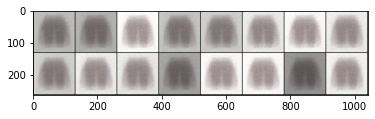

In [25]:
imshow(torchvision.utils.make_grid(decoded_sample_images))